# Time Series Clustering

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from math import sqrt
from sklearn.metrics import classification_report
import random

## Generate data

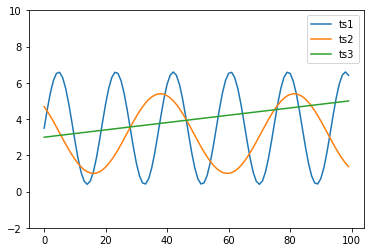

In [2]:
x=np.linspace(0,50,100)
ts1=pd.Series(3.1*np.sin(x/1.5)+3.5)
ts2=pd.Series(2.2*np.sin(x/3.5+2.4)+3.2)
ts3=pd.Series(0.04*x+3.0)

ts1.plot()
ts2.plot()
ts3.plot()

plt.ylim(-2,10)
plt.legend(['ts1','ts2','ts3'])
plt.show()

## Distance meassures

#### Euclidean

In [3]:
def euclid_dist(ts1,ts2):
    return sqrt(sum((ts1-ts2)**2))

euclid_dist(ts1,ts2)

26.959216037969345

#### Distance Time Warping (DTW)

In [4]:
def dtw_dist(ts1, ts2):
    DTW={}
    
    for i in range(len(ts1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(ts2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(ts1)):
        for j in range(len(ts2)):
            dist= (ts1[i]-ts2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return sqrt(DTW[len(ts1)-1, len(ts2)-1])

dtw_dist(ts1, ts2)

17.929718468641138

In [5]:
def dtw_dist(ts1, ts2, w):
    
    DTW={}
    
    w = max(w, abs(len(ts1)-len(ts2)))
    
    for i in range(-1,len(ts1)):
        for j in range(-1,len(ts2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(ts1)):
        for j in range(max(0, i-w), min(len(ts2), i+w)):
            dist= (ts1[i]-ts2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return sqrt(DTW[len(ts1)-1, len(ts2)-1])

dtw_dist(ts1, ts2, 10)

18.59655183841726

In [6]:
def lbkeogh_dist(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return sqrt(LB_sum)

lbkeogh_dist(ts1, ts2, 10)

10.96456042004128

## Classification

In [7]:
def knn(train,test,w):
    preds=[]
    for ind,i in enumerate(test):
        min_dist=float('inf')
        closest_seq=[]
        #print ind
        for j in train:
            if lbkeogh_dist(i[:-1],j[:-1],5)<min_dist:
                dist=dtw_dist(i[:-1],j[:-1],w)
                if dist<min_dist:
                    min_dist=dist
                    closest_seq=j
        preds.append(closest_seq[-1])
    return classification_report(test[:,-1],preds)

In [8]:
def k_means_clust(data, num_clust, num_iter, w=5):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print(counter)
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if lbkeogh_dist(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    
    return centroids

## Testing

In [9]:
ts_train = np.genfromtxt('D:/data/csv/ts_train.csv', delimiter='\t')
ts_test = np.genfromtxt('D:/data/csv/ts_test.csv', delimiter='\t')

In [10]:
knn(ts_train,ts_test,4)

'              precision    recall  f1-score   support\n\n         1.0       1.00      0.96      0.98        50\n         2.0       0.96      1.00      0.98        50\n         3.0       1.00      1.00      1.00        50\n         4.0       0.98      1.00      0.99        50\n         5.0       1.00      1.00      1.00        50\n         6.0       1.00      0.98      0.99        50\n\n    accuracy                           0.99       300\n   macro avg       0.99      0.99      0.99       300\nweighted avg       0.99      0.99      0.99       300\n'

In [16]:
data=np.vstack((ts_train[:,:-1],ts_test[:,:-1]))

centroids = k_means_clust(data=data, num_clust=4, num_iter=10 , w=4)

#for i in centroids:
#    plt.plot(i)

#plt.show()

TypeError: Population must be a sequence or set.  For dicts, use list(d).

## Credits & Links

https://nbviewer.jupyter.org/github/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb